In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import cProfile
import time

import ase.io
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch

from utils.combine import CombineRadial, CombineRadialSpecies, CombineSpecies
from utils.dataset import AtomisticDataset, create_dataloader
from utils.linear import LinearModel
from utils.operations import SumStructures, remove_gradient
from utils.soap import PowerSpectrum

torch.set_default_dtype(torch.float64)

In [3]:
n_test = 100
n_train = 100

frames = ase.io.read("data/xyz/data_shuffle.xyz", f":{n_test + n_train}")

train_frames = frames[:n_train]
test_frames = frames[-n_test:]

train_energies = torch.tensor(
    [frame.info["energy"] for frame in train_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

test_energies = torch.tensor(
    [frame.info["energy"] for frame in test_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

train_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype())
    for frame in train_frames
]

test_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype()) 
    for frame in test_frames
]

print(f"using {n_train} training frames")

using 100 training frames


In [4]:
all_species = set()
for frame in frames:
    all_species.update(frame.numbers)

all_species = list(map(lambda u: int(u), all_species))

# HYPERS_FROM_PAPER = {
#     "interaction_cutoff": 5.0,
#     "max_angular": 9,
#     "max_radial": 12,
#     "gaussian_sigma_constant": 0.3,
#     "gaussian_sigma_type": "Constant",
#     "cutoff_smooth_width": 0.5,
#     "radial_basis": "GTO",
#     "compute_gradients": False,
#     "expansion_by_species_method": "user defined",
#     "global_species": all_species,
# }

HYPERS_SMALL = {
    "cutoff": 4.0,
    "max_angular": 4,
    "max_radial": 6,
    "atomic_gaussian_width": 0.3,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"SplinedGto": {"accuracy": 1e-6}},
    "gradients": False,
    "center_atom_weight": 1.0,
    # # TODO: implement this in rascaline itself
    # "radial_per_angular": {
    #     # l: n
    #     0: 10,
    #     1: 8,
    #     2: 8,
    #     3: 4,
    #     4: 4,
    # }
}

# Optimization loop, energies only

In [5]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

In [7]:
train_dataset = AtomisticDataset(train_frames, all_species, HYPERS_SMALL, train_energies, radial_spectrum_n_max=12)
test_dataset = AtomisticDataset(test_frames, all_species, HYPERS_SMALL, test_energies, radial_spectrum_n_max=12)

HYPERS_GRAD = copy.deepcopy(HYPERS_SMALL)
HYPERS_GRAD["gradients"] = True
train_dataset_grad = AtomisticDataset(train_frames, all_species, HYPERS_GRAD, train_energies, train_forces, radial_spectrum_n_max=12)
test_dataset_grad = AtomisticDataset(test_frames, all_species, HYPERS_GRAD, test_energies, test_forces, radial_spectrum_n_max=12)

In [8]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    device=device,
)

train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

train_dataloader_single_frame = create_dataloader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    device=device,
)

train_dataloader_grad = create_dataloader(
    train_dataset_grad,
    batch_size=50,
    shuffle=True,
    device=device,
)

train_dataloader_grad_no_batch = create_dataloader(
    train_dataset_grad,
    batch_size=len(train_dataset_grad),
    shuffle=False,
    device=device,
)

test_dataloader = create_dataloader(
    test_dataset,
    batch_size=100,
    shuffle=False,
    device=device,
)

test_dataloader_grad = create_dataloader(
    test_dataset_grad,
    batch_size=50,
    shuffle=False,
    device=device,
)

In [11]:
def loss_mae(predicted, actual):
    return torch.mean(torch.abs(predicted.flatten() - actual.flatten()))

def loss_mse(predicted, actual):
    return torch.mean((predicted.flatten() - actual.flatten())**2)

In [19]:
class CombinedPowerSpectrum(torch.nn.Module):
    def __init__(self, combiner):
        super().__init__()

        self.combiner = combiner
        self.power_spectrum = PowerSpectrum()

    def forward(self, spherical_expansion):
        combined = self.combiner(spherical_expansion)

        return self.power_spectrum(combined)

        
class MultiBodyOrderModel(torch.nn.Module):
    def __init__(
        self, 
        power_spectrum,
        radial_spectrum_regularizer,
        power_spectrum_regularizer,
        optimizable_weights,
        random_initial_weights,
    ):
        super().__init__()

        self.sum_structure = SumStructures()

        # optimizable_weights = False is not very well tested ...
        assert optimizable_weights

        self.power_spectrum = power_spectrum

        if radial_spectrum_regularizer is None:
            self.radial_spectrum_model = None
        else:
            self.radial_spectrum_model = LinearModel(
                regularizer=radial_spectrum_regularizer,
                optimizable_weights=optimizable_weights,
                random_initial_weights=random_initial_weights,
            )

        self.power_spectrum_model = LinearModel(
            regularizer=power_spectrum_regularizer,
            optimizable_weights=optimizable_weights,
            random_initial_weights=random_initial_weights,
        )

        self.optimizable_weights = optimizable_weights
        self.random_initial_weights = random_initial_weights

    def forward(self, frames, radial_spectrum, spherical_expansion, forward_forces=False):
        if not forward_forces:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)
            
        power_spectrum = self.power_spectrum(spherical_expansion)
        power_spectrum_per_structure = self.sum_structure(power_spectrum)

        radial_spectrum_per_structure = self.sum_structure(radial_spectrum)

        energies, forces = self.power_spectrum_model(power_spectrum_per_structure, with_forces=forward_forces)
        
        if self.radial_spectrum_model is not None:
            energies_rs, forces_rs = self.radial_spectrum_model(radial_spectrum_per_structure, with_forces=forward_forces)
            energies += energies_rs
            if forces_rs is not None:
                forces += forces_rs
    
        return energies, forces

    def initialize_model_weights(self, frames, radial_spectrum, spherical_expansion, energies, forces=None):
        if forces is None:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)
            
        power_spectrum = self.power_spectrum(spherical_expansion)
        power_spectrum_per_structure = self.sum_structure(power_spectrum)

        radial_spectrum_per_structure = self.sum_structure(radial_spectrum)

        self.power_spectrum_model.initialize_model_weights(power_spectrum_per_structure, energies, forces)

        if self.radial_spectrum_model is not None:
            self.radial_spectrum_model.initialize_model_weights(radial_spectrum_per_structure, energies, forces)

        

In [20]:
# species combination only
N_PSEUDO_SPECIES = 4
combiner = CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES)

# # species combination and then radial basis combination
# N_COMBINED_RADIAL = 4
# combiner = torch.nn.Sequential(
#     CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES),
#     CombineRadial(max_radial=HYPERS_SMALL["max_radial"], n_combined_radial=N_COMBINED_RADIAL),
# )

# # combine both radial and species information at the same time
# combiner = CombineRadialSpecies(
#     n_species=len(all_species), 
#     max_radial=HYPERS_SMALL["max_radial"], 
#     n_combined_basis=N_COMBINED_RADIAL*N_PSEUDO_SPECIES,
# )

power_spectrum = CombinedPowerSpectrum(combiner)

LINALG_REGULARIZER_ENERGIES = 1e-2
LINALG_REGULARIZER_FORCES = 1e-1

model = MultiBodyOrderModel(
    power_spectrum=power_spectrum, 
    radial_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    power_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=True, 
    random_initial_weights=True,
)

if model.optimizable_weights:
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 1e-2
    TORCH_REGULARIZER_POWER_SPECTRUM = 1e-2
else:
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 0.0
    TORCH_REGULARIZER_POWER_SPECTRUM = 0.0

In [22]:
model.to(device=device, dtype=torch.get_default_dtype())

if model.random_initial_weights:
    dataloader_initialization = train_dataloader_single_frame
else:
    dataloader_initialization = train_dataloader_no_batch

# initialize the model
with torch.no_grad():
    for frames, radial_spectrum, spherical_expansions, energies, _ in dataloader_initialization:
        # we want to intially train the model on all frames, to ensure the
        # support points come from the full dataset.
        model.initialize_model_weights(frames, radial_spectrum, spherical_expansions, energies)
        break

del radial_spectrum, spherical_expansions

In [23]:
lr = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, line_search_fn="strong_wolfe")

all_losses = []

filename = f"{model.__class__.__name__}-{N_PSEUDO_SPECIES}-mixed-{n_train}-train"
if model.optimizable_weights:
    filename += "-opt-weights"

if model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [26]:
assert model.optimizable_weights

for epoch in range(5):
    epoch_start = time.time()

    optimizer.zero_grad()
    def single_step():
        for frame, radial_spectrum, spherical_expansions, energies, _ in train_dataloader:            
            predicted, _ = model(frame, radial_spectrum, spherical_expansions, forward_forces=False)

            loss = loss_mse(predicted, energies)
            # regularization
            # TODO: how does this interact with backward prop??
            loss += TORCH_REGULARIZER_RADIAL_SPECTRUM * torch.linalg.norm(model.radial_spectrum_model.weights)
            loss += TORCH_REGULARIZER_POWER_SPECTRUM * torch.linalg.norm(model.power_spectrum_model.weights)

            loss.backward(retain_graph=False)

        return loss
            
    loss = optimizer.step(single_step)
    loss = loss.item()
    all_losses.append(loss)

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        with torch.no_grad():
            predicted = []
            reference = []
            for frame, radial_spectrum, spherical_expansions, energies, _ in test_dataloader:
                reference.append(energies)
                predicted_e, _ = model(frame, radial_spectrum, spherical_expansions, forward_forces=False)
                predicted.append(predicted_e)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            mae = loss_mae(predicted, reference)

            output.write(f"{n_epochs_total} {loss} {mae}\n")
            output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss:.4}, test mae={mae:.4}")
    
    del spherical_expansions, loss, mae
        
    n_epochs_total += 1

epoch 0 took 14.12s, optimizer loss=1.127e+05, test mae=208.1
epoch 1 took 9.568s, optimizer loss=4.682e+04, test mae=190.0
epoch 2 took 12.66s, optimizer loss=3.95e+04, test mae=181.4
epoch 3 took 10.05s, optimizer loss=3.843e+04, test mae=182.5
epoch 4 took 9.985s, optimizer loss=3.824e+04, test mae=182.1


# Predicting forces with forward propagation

In [29]:
def evaluate_model_with_forces(model, dataloader):
    predicted_e = []
    reference_e = []
    predicted_f = []
    reference_f = []
    for frame, radial_spectrum, spherical_expansions, energies, forces in dataloader:
        reference_e.append(energies)
        reference_f.append(forces)
        e, f = model(frame, radial_spectrum, spherical_expansions, forward_forces=True)
        predicted_e.append(e)
        predicted_f.append(f)

    reference_e = torch.vstack(reference_e)
    predicted_e = torch.vstack(predicted_e)

    reference_f = torch.vstack(reference_f)
    predicted_f = torch.vstack(predicted_f)

    return reference_e, predicted_e, reference_f, predicted_f

In [30]:
def parity_plots(reference_e, predicted_e, reference_f, predicted_f):
    predicted_e = predicted_e.detach()
    predicted_f = predicted_f.detach()

    fig, (ax_e, ax_f) = plt.subplots(1, 2, figsize=(16, 8))

    mae = loss_mae(predicted_e, reference_e)
    rmse = loss_rmse(predicted_e, reference_e)
    ax_e.scatter(reference_e.cpu(), predicted_e.cpu())
    x = (torch.min(reference_e.flatten()).item(), torch.max(reference_e.flatten()).item())
    ax_e.plot(x, x, color="red")
    ax_e.set_title(f"energies, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_e.set_xlabel("actual")
    ax_e.set_ylabel("predicted")

    mae = loss_mae(predicted_f, reference_f)
    rmse = loss_rmse(predicted_f, reference_f)
    ax_f.scatter(reference_f.cpu(), predicted_f.cpu())
    x = (torch.min(reference_f.flatten()).item(), torch.max(reference_f.flatten()).item())
    ax_f.plot(x, x, color="red")
    ax_f.set_title(f"forces, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_f.set_xlabel("actual")
    ax_f.set_ylabel("predicted")

    return fig

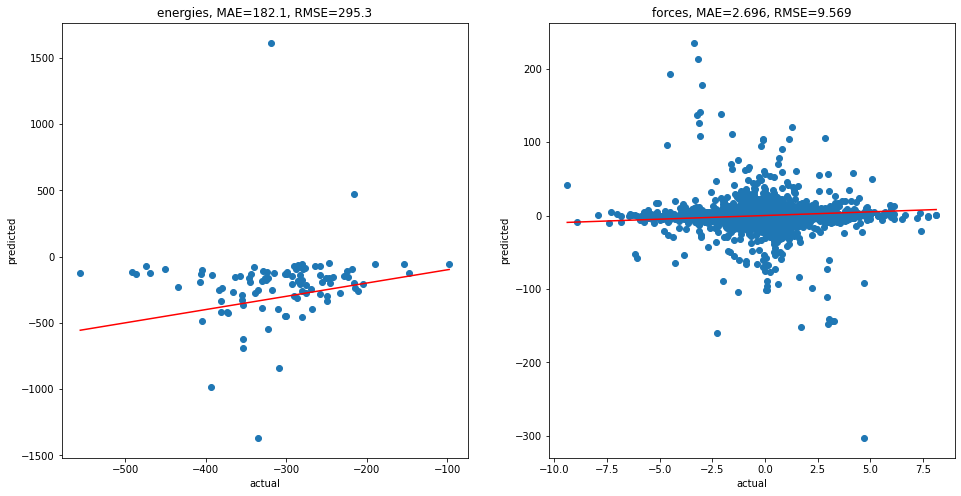

In [31]:
fig = parity_plots(*evaluate_model_with_forces(model, test_dataloader_grad))

In [34]:
def check_finite_differences(model, frame, delta=1e-6):
    frame = frame.copy()
    delta_frame = frame.copy()
    delta_frame.positions[3, 1] += delta

    dataset = AtomisticDataset(
        [frame, delta_frame], 
        all_species, 
        HYPERS_GRAD, 
        torch.zeros(2, 1), 
        radial_spectrum_n_max=12,
    )
    dataloader = create_dataloader(
        dataset,
        batch_size=len(dataset),
        shuffle=False,
        device=device,
    )

    for frame, radial_spectrum, spherical_expansions, _, _ in dataloader:
        predicted_e, predicted_f = model(frame, radial_spectrum, spherical_expansions, forward_forces=True)

    finite_diff = - (predicted_e[1] - predicted_e[0]) / delta
    print("finite difference =", finite_diff.item())
    print("computed gradient =", predicted_f[3, 1].item())

In [35]:
if torch.get_default_dtype() == torch.float64:
    delta = 1e-6
else:
    delta = 1e-3

check_finite_differences(model, train_frames[22], delta)

finite difference = 2.1691560618819494
computed gradient = 2.1691519933961025
